# Delta Hedging and Monte-Carlo Simulation Pt 3

**Fall 2025 Quantiative Methods in Finance**

**The Erdös Institute**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm

sns.set_style('darkgrid')

In [3]:
##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    
    
    return call_value
    


def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of put option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)
    
    
    return put_value


def bs_call_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Call Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call option with respect to S_0
    
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Put Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of put option with respect to S_0
    
    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return -1 + norm.cdf(d1)


def bs_vega(S0, K, sigma, t, r):
    '''Black-Scholes vega of Call & Put Options
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call & put option with respect to sigma
    
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return S0*norm.pdf(d1)*np.sqrt(t)

In [4]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps
    
    Return (np.array): Array of stock paths
    """
    
    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

## $\Delta$-hedging and removing the influence of stock drift in option pricing


### Expected call payout and Delta with stock drift vs without drift

Let $0<t$ and assume the price of stock $S_t$ at time $t$ follows a Geometric Brownian Motion with drift term $\mu$,

$$S_{t} = S_{0}e^{\left(\mu+r -\frac{\sigma^2}{2} \right)(t) + \sigma\sqrt{t}\mathcal{N}(0,1)}.$$


Let $S_{t,RF}$ denote the risk-free distribution

$$S_{t,RF} = S_{0}e^{\left(r -\frac{\sigma^2}{2} \right)(t) + \sigma\sqrt{t}\mathcal{N}(0,1)}.$$

Let $K$ be the strike of a call option expiring at time $t$ and consider the expected call payoffs

$$C_0 = e^{-rt}\mathbb{E}[\max(S_t-K,0)] \quad \text{and}\quad C_{0,RF} = e^{-rt}\mathbb{E}[\max(S_{t,RF}-K,0)].$$

Then 

$$C_0 = S_0e^{\mu t}\Phi\left(d_1 + \frac{\mu}{\sigma}\sqrt{t}\right) - Ke^{-rt}\Phi\left(d_2 + \frac{\mu}{\sigma}\sqrt{t}\right) \quad \text{and}\quad C_{0,RF} = S_0\Phi\left(d_1\right) - Ke^{-rt}\Phi\left(d_2\right)$$

where $d_1$ and $d_2$ are the usual values used in the closed-form solution of the Black-Scholes equation. 

The differences $|C_0 - C_{0, RF}|$ and $\left| \frac{\partial C_0}{\partial S_0} - \frac{\partial C_{0,RF}}{\partial S_{0,RF}} \right|$ are linear functions of $\int_{d_1}^{d_1+\frac{\mu}{\sigma}\sqrt{t}}\varphi(x)\,dx$ and $\int_{d_2}^{d_2+\frac{\mu}{\sigma}\sqrt{t}}\varphi(x)\,dx$.

Consequently, as $t\to 0^+$, the differences $|C_0 - C_{0, RF}|$ and $\left| \frac{\partial C_0}{\partial S_0} - \frac{\partial C_{0,RF}}{\partial S_{0,RF}} \right|$ converge to $0$ at a linear rate (with respect to $t$).


### Hedging and the removal of drift

Assume a stock path follows a Geometric Brownian Motion with drift term $\mu$. That is if $t_1<t_2$, then

$$S_{t_2} = S_{t_1}e^{\left(\mu+r -\frac{\sigma^2}{2} \right)(t_2-t_1) + \sigma\sqrt{t_2-t_1}\mathcal{N}(0,1)}.$$

Consider a call option on a stock at time $0$ that expires at time $t$.  Let $0 = t_0<t_1<\cdots<t_{n-1}<t_n = t$ and consider the profit distirbution of a portfolio that owns the option contract and creates $\Delta$-neutral posititions at times $t_0, t_1, \ldots, t_{n-1}$ by shorting $\Delta_{C_{t_i}}$ shares of stock at time $t_i$. The portfolio's profit, discounted to time $0$ is

$$\max(S_t-K,0)e^{-rt} - \sum_{i=0}^{n-1} (S_{t_{i+1}}- e^{r(t_{i+1}-t_{i})}S_{t_{i}})\Delta_{C_{t_{i}}}e^{-rt_{i+1}}.$$

If the intervals $[t_i, t_{i+1}] are small enough, then there is an approximation

$$(S_{t_{i+1}}- e^{r(t_{i+1}-t_{i})}S_{t_{i}})\Delta_{C_{t_{i}}} \sim (S_{t_{i+1}}- e^{r(t_{i+1}-t_{i})}S_{t_{i}})\frac{C_{t_{i}, RF}(S_{t_{i+1}})-C_{t_i, RF}}{(S_{t_{i+1}}- e^{r(t_{i+1}-t_{i})}S_{t_{i}})} = C_{t_{i+1}, RF}-e^{r(t_{i+1}-t_i)}C_{t_i, RF}. $$

Hence there is an approximation

$$\max(S_t-K,0)e^{-rt} - \sum_{i=0}^{n-1} (S_{t_{i+1}}- e^{r(t_{i+1}-t_{i})}S_{t_{i}})\Delta_{C_{t_{i}}}e^{-rt_{i+1}} \sim \max(S_t - K, 0) - C_{t, RF} + C_{0,RF}.$$

The value $C_{t, RF}$ is being meaured over the time interval from $t_{n-1}$ to $t_n=t$. Hence  

In [ ]:
### Explore the effect of increased number of deltas hedges on a stock path

### Explore hedging profit distriubtions on numerous stock path simulations

### Explore MC methods for Delta

### Construct true MC simulation, i.e. no Black-Scholes formulas

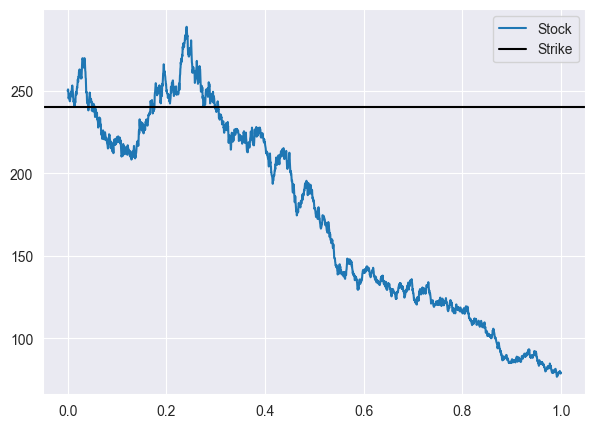

Simulated Call Option Value with 2520 hedges: $48.25
Call option payout with no hedging: $0.00
Black-Scholes Call Option Value: $48.91


In [60]:
S0 = 250

K = 240

sigma = .41

t = 1

r = 0.035

mu = -.5

n_sims = 1

n_steps = 2520


stock_path = GBM_paths(S0,sigma, t, r, mu, n_sims, n_steps)[0]



call_payout_discounted = np.maximum(stock_path[-1] - K, 0)*np.exp(-r*t)



times = np.linspace(0, t, n_steps + 1)

dt = t/n_steps


deltas = bs_call_delta(stock_path[0:n_steps], K, sigma, (t- times)[0:n_steps], r)

stock_profits_discounted = (stock_path[1:n_steps + 1] - \
                            stock_path[0:n_steps]*np.exp(r*dt))*np.exp(-r*times[1:n_steps+1])*deltas


total_stock_profits = np.sum(stock_profits_discounted)


profit_of_call_with_hedging = call_payout_discounted - total_stock_profits


bs_call_price = bs_call(S0,K,sigma,t,r)


plt.figure(figsize = (7,5))

plt.plot(times, stock_path, label = 'Stock')

plt.axhline(K, label = 'Strike', color = 'black')

plt.legend()

plt.show()


print(f'Simulated Call Option Value with {n_steps} hedges: ${profit_of_call_with_hedging:.2f}')

print(f'Call option payout with no hedging: ${call_payout_discounted:.2f}')


print(f'Black-Scholes Call Option Value: ${bs_call_price:.2f}')

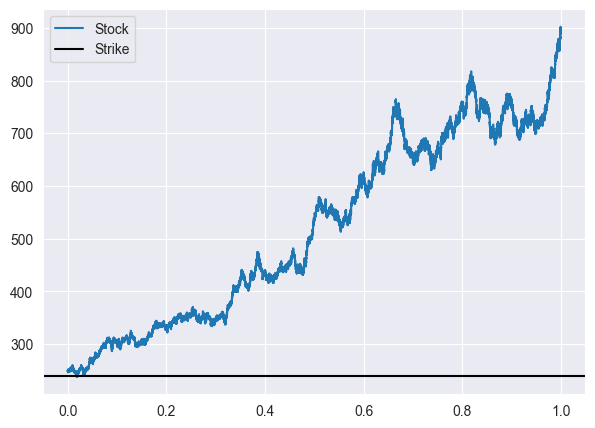

Simulated Portfolio profit 50400 hedges: $2.07
Portfolio profit no hedging: $-583.91
Expected Profit: $2.09


In [89]:
#Market maker's point of view

S0 = 250

K = 240

sigma = .41

t = 1

r = 0.035

mu = 1

n_sims = 1

n_steps = 252*200

premium = 51


stock_path = GBM_paths(S0,sigma, t, r, mu, n_sims, n_steps)[0]



call_payout_discounted = np.maximum(stock_path[-1] - K, 0)*np.exp(-r*t)



times = np.linspace(0, t, n_steps + 1)

dt = t/n_steps


deltas = bs_call_delta(stock_path[0:n_steps], K, sigma, (t- times)[0:n_steps], r)

stock_profits_discounted = (stock_path[1:n_steps + 1] - \
                            stock_path[0:n_steps]*np.exp(r*dt))*np.exp(-r*times[1:n_steps+1])*deltas


total_stock_profits = np.sum(stock_profits_discounted)


profit_of_call_with_hedging = call_payout_discounted - total_stock_profits


hedged_portfolio_selling_call = premium - profit_of_call_with_hedging


bs_call_price = bs_call(S0,K,sigma,t,r)


expected_portfolio_profit = premium - bs_call_price


plt.figure(figsize = (7,5))

plt.plot(times, stock_path, label = 'Stock')

plt.axhline(K, label = 'Strike', color = 'black')

plt.legend()

plt.show()


print(f'Simulated Portfolio profit {n_steps} hedges: ${hedged_portfolio_selling_call:.2f}')

print(f'Portfolio profit no hedging: ${premium - call_payout_discounted:.2f}')


print(f'Expected Profit: ${expected_portfolio_profit:.2f}')

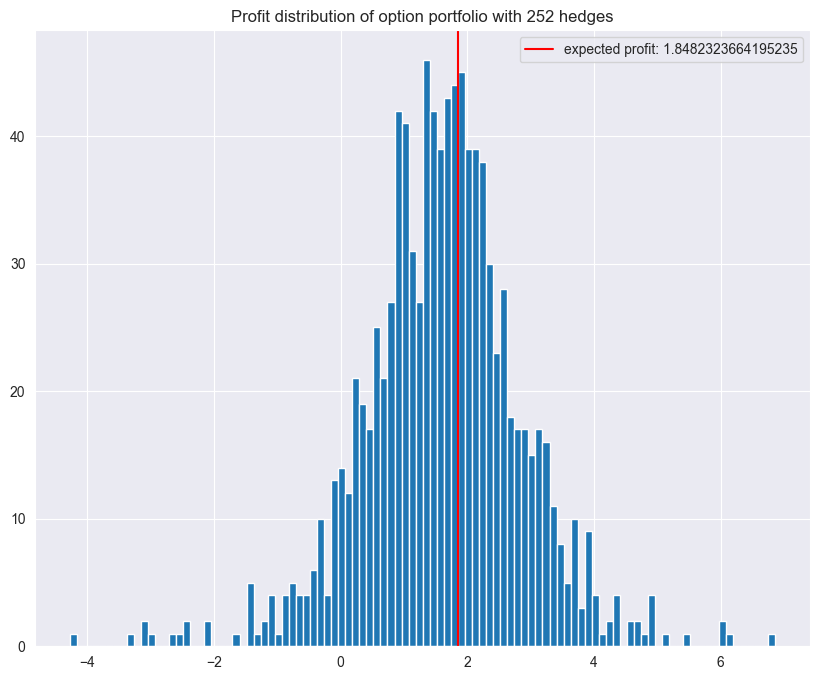

In [80]:
# We can look at distriubtions of profits with hedging


#Market maker's point of view

S0 = 250

K = 240

sigma = .41

t = 1

r = 0.035

mu = 1

n_sims = 1000

n_steps = 252

premium = bs_call(S0, K, sigma + .02, t, r)


stock_paths = GBM_paths(S0,sigma, t, r, mu, n_sims, n_steps)



call_payout_discounted = np.maximum(stock_paths[:,-1] - K, 0)*np.exp(-r*t)



times = np.linspace(0, t, n_steps + 1)

dt = t/n_steps





deltas = bs_call_delta(stock_paths[:,0:n_steps], K, sigma, (t- times)[0:n_steps], r)

stock_profits_discounted = (stock_paths[:,1:n_steps + 1] - \
                            stock_paths[:,0:n_steps]*np.exp(r*dt))*np.exp(-r*times[1:n_steps+1])*deltas


total_stock_profits = np.sum(stock_profits_discounted, axis = 1)


profit_of_call_with_hedging = call_payout_discounted - total_stock_profits


hedged_portfolio_selling_call = premium - profit_of_call_with_hedging


bs_call_price = bs_call(S0,K,sigma,t,r)


expected_portfolio_profit = premium - bs_call_price


simulated_portfolio_profit_avg = np.mean(hedged_portfolio_selling_call)


plt.figure(figsize = (6,4))

plt.hist(hedged_portfolio_selling_call, bins = 100)
plt.title(f'Profit distribution of option portfolio with {n_steps} hedges')

plt.axvline(expected_portfolio_profit, color = 'red', label = f'expected profit: {expected_portfolio_profit}')

plt.legend()
plt.show()

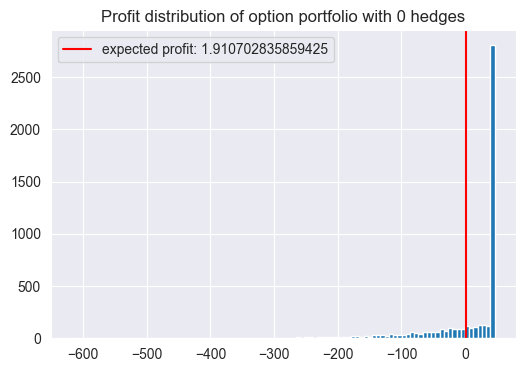

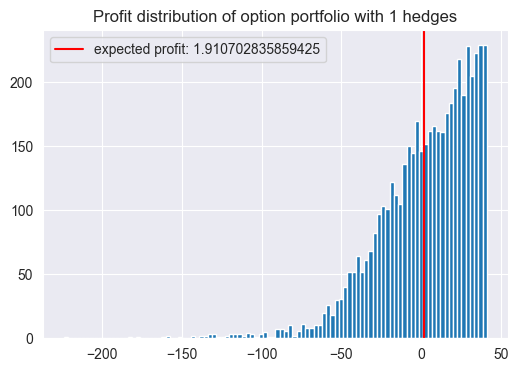

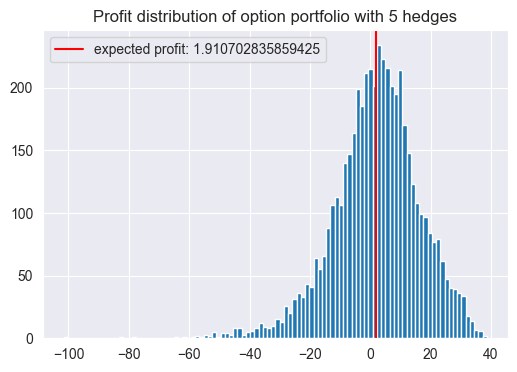

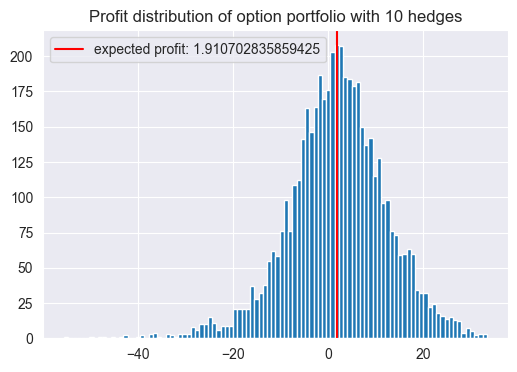

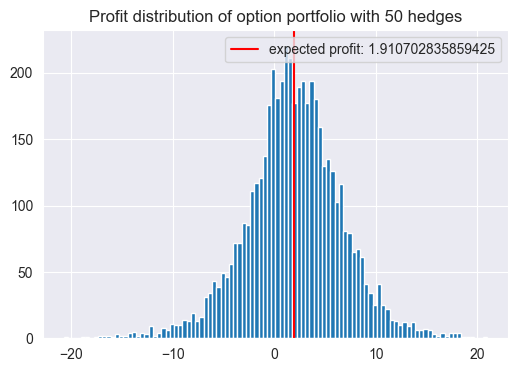

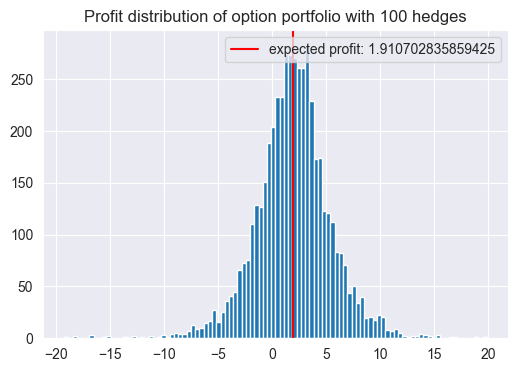

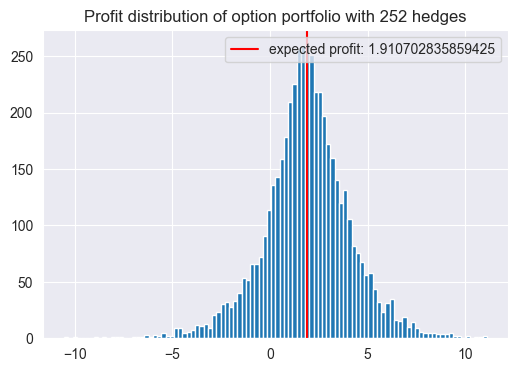

In [87]:
# We can look at distriubtions of profits with hedging


#Market maker's point of view

S0 = 250

K = 250

sigma = .41

t = 1

r = 0.035

mu = 0

n_sims = 5000

step_amounts = [1, 5, 10, 50, 100, 252]

premium = bs_call(S0, K, sigma + .02, t, r)


## Profit Distribution of 0 hedges

stock_paths = GBM_paths(S0,sigma, t, r, mu, n_sims, 1)



call_payout_discounted = np.maximum(stock_paths[:,-1] - K, 0)*np.exp(-r*t)



portfolio_selling_call = premium - call_payout_discounted


bs_call_price = bs_call(S0,K,sigma,t,r)


expected_portfolio_profit = premium - bs_call_price


simulated_portfolio_profit_avg = np.mean(portfolio_selling_call)



plt.figure(figsize = (6,4))

plt.hist(portfolio_selling_call, bins = 100)
plt.title(f'Profit distribution of option portfolio with 0 hedges')

plt.axvline(simulated_portfolio_profit_avg, color = 'red', label = f'expected profit: {expected_portfolio_profit}')

plt.legend()
plt.show()


for n_steps in step_amounts:


    stock_paths = GBM_paths(S0,sigma, t, r, mu, n_sims, n_steps)



    call_payout_discounted = np.maximum(stock_paths[:,-1] - K, 0)*np.exp(-r*t)



    times = np.linspace(0, t, n_steps + 1)

    dt = t/n_steps





    deltas = bs_call_delta(stock_paths[:,0:n_steps], K, sigma, (t- times)[0:n_steps], r)

    stock_profits_discounted = (stock_paths[:,1:n_steps + 1] - \
                                stock_paths[:,0:n_steps]*np.exp(r*dt))*np.exp(-r*times[1:n_steps+1])*deltas


    total_stock_profits = np.sum(stock_profits_discounted, axis = 1)


    profit_of_call_with_hedging = call_payout_discounted - total_stock_profits


    hedged_portfolio_selling_call = premium - profit_of_call_with_hedging


    bs_call_price = bs_call(S0,K,sigma,t,r)


    expected_portfolio_profit = premium - bs_call_price


    simulated_portfolio_profit_avg = np.mean(hedged_portfolio_selling_call)


    plt.figure(figsize = (6,4))

    plt.hist(hedged_portfolio_selling_call, bins = 100)
    plt.title(f'Profit distribution of option portfolio with {n_steps} hedges')

    plt.axvline(expected_portfolio_profit, color = 'red', label = f'expected profit: {expected_portfolio_profit}')

    plt.legend()
    plt.show()

In [107]:
S0 = 250

K = 250

sigma = .42

t = 1

r = .035

mu = -.25

n_sims = 500

n_steps = 252




stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)

stock_paths_avgs = np.mean(stock_paths, axis = 0)

times = np.linspace(0, t, n_steps + 1)

dt = t/n_steps


noise = np.random.normal(size = (100, n_sims, n_steps))


exponent = (r-sigma**2*(0.5))*np.tile((t-times)[0:n_steps], (100, n_sims ,1))\
+ sigma*np.sqrt(np.tile((t-times)[0:n_steps], (100,n_sims ,1)))*noise


deltas_up = (stock_paths[:,0:n_steps] + .01)*np.exp(exponent)

deltas_down = (stock_paths[:,0:n_steps] - .01)*np.exp(exponent)

deltas = np.mean((np.maximum(deltas_up - K, 0) - np.maximum(deltas_down - K, 0))/(.02), axis = 0)


stock_profits = deltas*(stock_paths[:,1:n_steps+1] - np.exp(r*dt)*stock_paths[:,0:n_steps])

stock_profits_discounted = stock_profits*np.exp(-r*times[1:n_steps+1])

total_stock_profits = np.sum(stock_profits_discounted, axis = 1)

call_payouts_discounted = np.maximum(stock_paths[:,-1]-K,0)*np.exp(-r*t)


hedged_profits = call_payouts_discounted - total_stock_profits

np.mean(hedged_profits), bs_call(S0, K, sigma, t,r)

(45.91218306533697, 45.30701855113837)